<a href="https://colab.research.google.com/github/BatoolAshour/KaustAcademy-Stage3-ExSolutions/blob/main/Copy_of_Day2_1_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image.png](https://i.imgur.com/a3uAqnb.png)

# **📌 Working with Different Dataset Structures**
---

## **Purpose of This Lab**

In real-world projects, datasets don't always come in the same format:
- Some are **pre-split** into train/validation/test folders
- Others are **unsplit**, requiring you to create splits manually
- Some include **CSV files** with labels, while others use **folder-based labels**
- Segmentation datasets have **paired images and masks** instead of class labels
- Plotting some

**This lab trains you to:**
1. **Inspect and understand** different dataset structures
2. **Build custom Dataset classes** for various data formats
3. **Handle both classification and segmentation** datasets
4. **Debug and visualize** data before training

By the end of this lab, you will be confident working with any dataset structure you encounter.

---

## **What We Will Cover**

### **Part 1: Image Classification Datasets**
- Pre-split datasets (train/val/test folders already separated)
- Unsplit datasets (all images in one folder, requiring manual splitting)
- CSV-based datasets (labels stored in a CSV file)


✅ Debugging dataset loading issues

In [1]:
# Uncomment these lines if running on Google Colab
# import os
# os.environ["KAGGLEHUB_CACHE"] = "/content/data"

---

# **Part 1: Image Classification Datasets**

In this section, we'll work with **three types** of classification dataset structures:

1. **Pre-split dataset** - Already divided into train/validation/test folders
2. **Unsplit dataset** - All images in one folder, needs manual splitting
3. **CSV-labeled dataset** - Labels stored in a CSV file instead of folder names

We'll build a **complete example** for the first type, then leave the others as exercises.

## **Example 1: Pre-Split Dataset (Train/Val/Test)**

**Dataset:** Fruit and Vegetable Image Recognition  
**Structure:** Images are already organized into `train/`, `validation/`, and `test/` folders

This is the **easiest** type to work with because the data is already split for us.

In [2]:
# Import required libraries
import os
import kagglehub
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

## Fruits and Vegetables Image Recognition Dataset

![image.png](https://storage.googleapis.com/kaggle-datasets-images/952827/1613819/d6088a240b65b74c5b8fa735958b08c5/dataset-cover.jpg?t=2020-11-03-05-53-42)

In [3]:
# Download the dataset from Kaggle
path = kagglehub.dataset_download("kritikseth/fruit-and-vegetable-image-recognition")
print("Dataset downloaded to:", path)

Using Colab cache for faster access to the 'fruit-and-vegetable-image-recognition' dataset.
Dataset downloaded to: /kaggle/input/fruit-and-vegetable-image-recognition


### **Step 1: Inspect the Dataset Structure**

Before writing any code, **always** inspect the dataset structure first.  
This helps you understand:
- How folders are organized
- Where images are located
- How labels are defined (folder names, CSV, etc.)

In [4]:
train_path= os.path.join(path,'train')

print("\nClasses in train folder (first 10):")
classes= sorted(os.listdir(train_path))
for i , class_name in enumerate(classes[:10]):
  class_path = os.path.join(train_path, class_name)
  num_images= len(os.listdir(class_path))
  print(f"  {i}: {class_name} - {num_images} images")

print(f"\nTotal classes: {len(classes)}")


Classes in train folder (first 10):
  0: apple - 68 images
  1: banana - 75 images
  2: beetroot - 88 images
  3: bell pepper - 90 images
  4: cabbage - 92 images
  5: capsicum - 89 images
  6: carrot - 82 images
  7: cauliflower - 79 images
  8: chilli pepper - 87 images
  9: corn - 87 images

Total classes: 36


In [5]:
 #List the contents of the dataset directory
print("Top-level contents:")
for item in os.listdir(path):
    item_path = os.path.join(path, item)
    if os.path.isdir(item_path):
        print(f"📁 {item}/")
    else:
        print(f"📄 {item}")

Top-level contents:
📁 validation/
📁 test/
📁 train/


**What we discovered:**
- ✅ Folders: `train/`, `validation/`, `test/`
- ✅ Each folder contains subfolders named by class (e.g., `apple`, `banana`)
- ✅ Each class subfolder contains images of that class
- ✅ **Labels come from folder names** - this is called "folder-based labeling"

**Key Insight:** The folder structure **IS** the labeling system.

### **Step 2: Build a Custom Dataset Class**

Now that we understand the structure, we need to create a **PyTorch Dataset class**.

**Why do we need a custom Dataset class?**
- PyTorch's `DataLoader` needs a standardized way to access data
- The Dataset class defines **how to load one sample** (image + label)
- It allows PyTorch to efficiently batch, shuffle, and load data in parallel

**Required Methods:**
1. `__init__()` - Initialize the dataset (scan folders, collect file paths)
2. `__len__()` - Return total number of samples
3. `__getitem__(idx)` - Load and return one sample at index `idx`

In [6]:
class FruitVegetableDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir=root_dir
    self.transform=transform

    #Get all class names (folder names)
    self.classes= sorted(os.listdir(root_dir))

    #Create a mapping from calss name to integer label
    self.class_to_idx = {class_name: i for i, class_name in enumerate(self.classes)}

    #Collect all image paths and their labels

    self.image_paths=[]
    self.labels=[]

    for class_name in self.classes:
      class_dir=os.path.join(root_dir, class_name)
      class_idx= self.class_to_idx[class_name]

      #get all image files in this class folder
      for img_name in os.listdir(class_dir):
        img_path= os.path.join(class_dir, img_name)
        self.image_paths.append(img_path)
        self.labels.append(class_idx)


  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    img_path = self.image_paths[idx]
    image= Image.open(img_path).convert("RGB")

    label= self.labels[idx]

    if self.transform:
      image= self.transform(image)

    return image, label

In [7]:
# Create datasets for train, validation, and test
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = FruitVegetableDataset(
    root_dir=os.path.join(path, "train"),
    transform=transform
)

val_dataset = FruitVegetableDataset(
    root_dir=os.path.join(path, "validation"),
    transform=transform
)

test_dataset = FruitVegetableDataset(
    root_dir=os.path.join(path, "test"),
    transform=transform
)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Classes: {train_dataset.classes[:5]}...")  # Show first 5 classes

Train samples: 3115
Validation samples: 351
Test samples: 359
Number of classes: 36
Classes: ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage']...


**Why is the Dataset class structured this way?**

1. **`__init__()` scans the dataset once:**
   - Builds lists of all image paths and labels
   - This is done **once** when creating the dataset, not every time we access a sample
   - Makes subsequent access very fast

2. **`__len__()` enables batching:**
   - DataLoader needs to know how many samples exist
   - Used to determine number of batches

3. **`__getitem__()` loads one sample on-demand:**
   - Called by DataLoader when creating batches
   - Loads image from disk **only when needed** (memory efficient)
   - Applies transforms (augmentation, normalization)

4. **Why convert to RGB?**
   - Some images might be grayscale or have alpha channel
   - `.convert('RGB')` ensures all images have 3 channels

### **Step 3: Visualize Dataset Samples**

Before training, it's **crucial** to visualize your data to ensure:
- Images are loading correctly
- Labels match the images
- Images are the expected size and format
- No corrupted or mislabeled data

Let's plot a few random samples from our training dataset.

In [8]:
import random
import numpy as np

# Create a function to visualize samples
def visualize_samples(dataset, num_samples=8, title="Dataset Samples"):
    """
    Visualize random samples from a dataset.

    Args:
        dataset: PyTorch Dataset object
        num_samples: Number of samples to display
        title: Title for the plot
    """
    # Select random indices
    indices = random.sample(range(len(dataset)), num_samples)

    # Calculate grid size
    cols = 4
    rows = (num_samples + cols - 1) // cols

    # Create the plot
    fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        # Get image and label
        image, label = dataset[idx]
        # Convert tensor to numpy for display
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()  # CHW -> HWC
        # Get class name
        class_name = dataset.classes[label]
        # Display image
        axes[i].imshow(image)
        axes[i].set_title(f"{class_name}\n(Label: {label})", fontsize=10)
        axes[i].axis('off')
    # Hide any unused subplots
    for i in range(num_samples, len(axes)):
        axes[i].axis('off')

    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

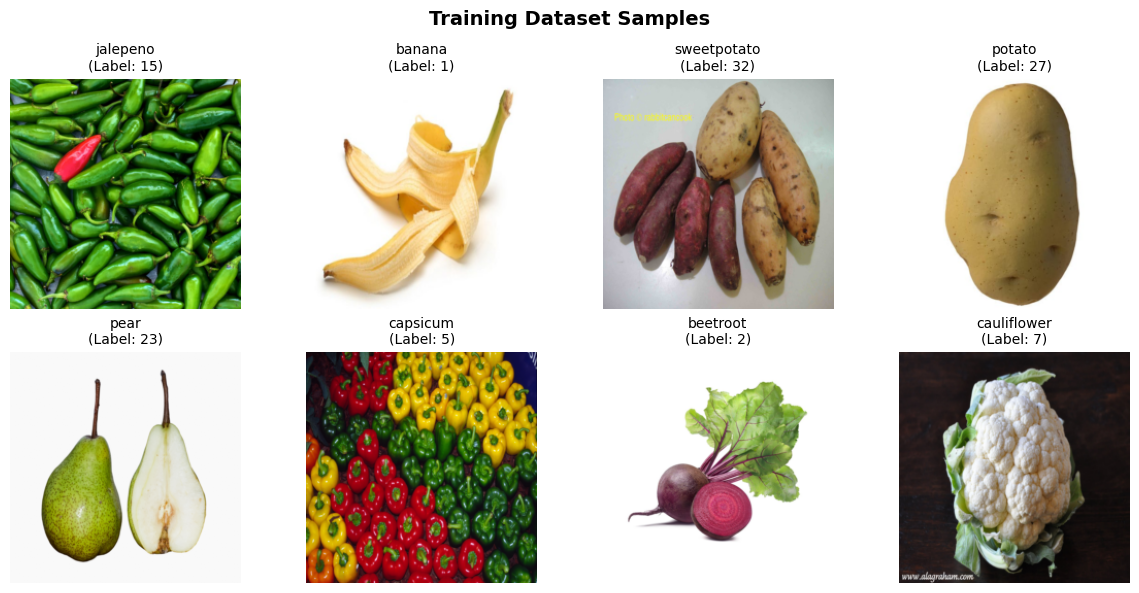

In [9]:
visualize_samples(train_dataset, num_samples=8, title="Training Dataset Samples")

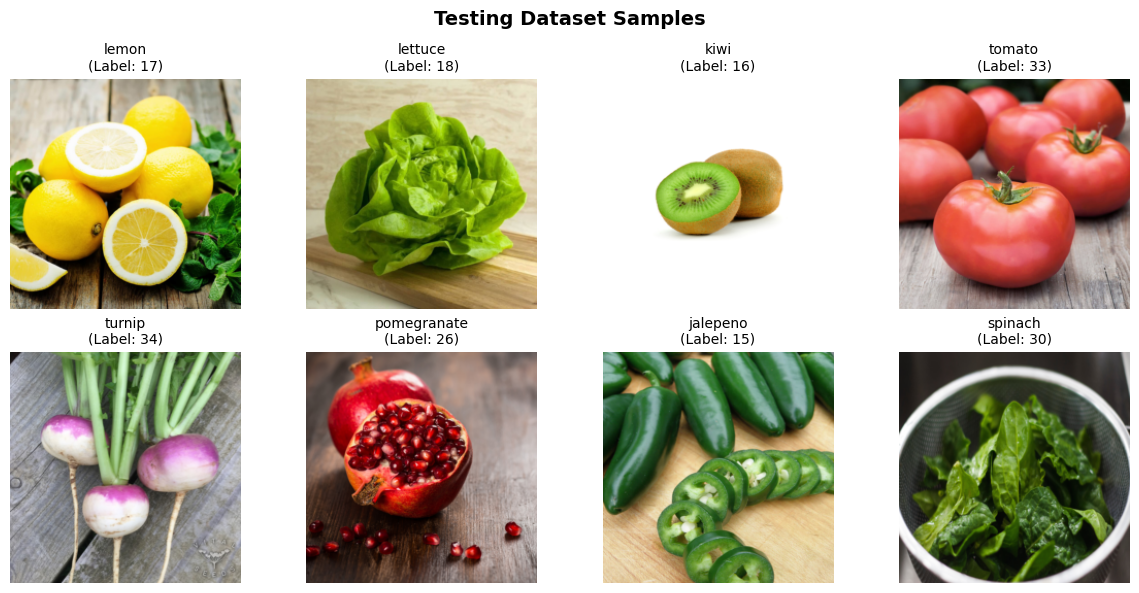

In [10]:
visualize_samples(test_dataset, num_samples=8, title="Testing Dataset Samples")

## Tire Texture Image Recognition

![image.png](https://storage.googleapis.com/kaggle-datasets-images/1731575/2830785/89236052a51930ac60fe7d2ccff1a48a/dataset-cover.jpeg?t=2021-11-19-19-33-01)

In [11]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jehanbhathena/tire-texture-image-recognition")        # Data Classified into train, test

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'tire-texture-image-recognition' dataset.
Path to dataset files: /kaggle/input/tire-texture-image-recognition


# TO-DO :)

In [12]:
import glob
class StandardDataset(Dataset):
  def __init__(self,root_dir, transform=None):
    self.root_dir=root_dir
    self.transform=transform

    # 1. Auto-generate class dictionary (or define manually)
        # Sort ensures 0=Apple, 1=Banana consistently
    classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
    self.class_labels = {cls_name: i for i, cls_name in enumerate(classes)}

    self.image_paths = []
    self.labels = []

    for class_name, label in self.class_labels.items():
      paths= glob.glob(f"{root_dir}/{class_name}/*.*") # Matches .jpg, .png etc
      self.image_paths.extend(paths)
      self.labels.extend([label] * len(paths))


  def __len__(self):
    return len(self.image_paths)

  def __getitem(self, idx):
    image = Image.open(self.image_paths[idx].convert("RGB"))
    label = self.labels[idx]

    if self.transform(image):
      image= self.transform(image)

    return image, label


In [13]:
transform= transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

train_dir= os.path.join(path,'Tire Textures', 'training_data')
test_dir= os.path.join(path, 'Tire Textures', 'testing_data')

from torchvision.datasets import ImageFolder

# Automatically handles everything if folders are named correctly
train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset  = ImageFolder(root=test_dir,  transform=transform)

#Don't use ImageFolder if:
  # Labels aren't tied to folder
  # Multiple labels per image
  # Dataset is not image-only

## **Example 2: CSV-Labeled Dataset (Unsplit)**

**Dataset:** 20 Fonts Classification  
**Structure:** All images in one folder + CSV file with labels

**Challenges:**
- Labels are in a CSV file, not folder names
- Data is **not split** - we need to create train/val/test splits manually
- Need to parse CSV to map images to labels

This is more complex but very common in real-world datasets.

## 20 Fonts Classification

![image.png](https://storage.googleapis.com/kaggle-datasets-images/6516839/10530509/966d95523da75a3a94efae86f08d8a62/dataset-cover.jpg?t=2025-01-20-20-36-23)/


In [14]:
import kagglehub

# Download latest version
fonts_path = kagglehub.dataset_download("samoilovmikhail/20-fonts-classification")            # Data given in one folder unsplitted + csv

print("Path to dataset files:", path)

Using Colab cache for faster access to the '20-fonts-classification' dataset.
Path to dataset files: /kaggle/input/tire-texture-image-recognition


### **Step 1: Inspect the Dataset Structure**

With CSV-based datasets, we need to:
1. Find the CSV file location
2. Understand the CSV format (columns, headers)
3. Locate the images folder
4. Check if images match the CSV entries

In [15]:
# Explore the dataset structure
print("Top-level contents:")
for item in os.listdir(fonts_path):
    item_path = os.path.join(fonts_path, item)
    if os.path.isdir(item_path):
        num_files = len(os.listdir(item_path))
        print(f"📁 {item}/ - {num_files} files")
    else:
        print(f"📄 {item}")

Top-level contents:
📁 files/ - 20000 files
📄 metadata.csv


In [16]:
import pandas as pd

# Find and load the CSV file
csv_files = [f for f in os.listdir(fonts_path) if f.endswith('.csv')]
print(f"CSV files found: {csv_files}\n")

# Load the CSV
csv_path = os.path.join(fonts_path, csv_files[0])
df = pd.read_csv(csv_path)

print(f"CSV shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}\n")
print("First 10 rows:")
print(df.head(10))

print(f"\nUnique labels: {df['Font'].nunique()}")
print(f"Label distribution:\n{df['Font'].value_counts().head(10)}")

CSV files found: ['metadata.csv']

CSV shape: (20000, 3)
Columns: ['FileName', 'Font', 'Text']

First 10 rows:
      FileName           Font      Text
0   file_1.png     CourierNew  Sediment
1   file_2.png          Arial     Guest
2   file_3.png  CenturyGothic    Socket
3   file_4.png        Verdana     Onset
4   file_5.png        Candara    Driver
5   file_6.png  TimesNewRoman   Oakland
6   file_7.png       Garamond     Breed
7   file_8.png  TimesNewRoman   Garrett
8   file_9.png       Palatino      Tens
9  file_10.png        Calibri      Arts

Unique labels: 20
Label distribution:
Font
CourierNew       1000
Arial            1000
CenturyGothic    1000
Verdana          1000
Candara          1000
TimesNewRoman    1000
Garamond         1000
Palatino         1000
Calibri          1000
Lobster          1000
Name: count, dtype: int64


**What we discovered:**
- ✅ CSV file contains `image` (filename) and `label` (class name) columns
- ✅ All images are in a single `data/` folder (not split by class)
- ✅ The dataset is **unsplit** - we'll need to create train/val/test splits
- ✅ Multiple fonts (classes) are represented

**Key Differences from Example 1:**
- Labels come from CSV, not folder structure
- Need to manually split the data
- All images mixed together in one folder

### **Step 2: Build a Custom Dataset Class for CSV-Based Data**

This Dataset class is different because:
1. **Reads labels from CSV** instead of folder names
2. **Supports train/val/test splitting** using indices
3. **No class folders** - all images in one location

We'll use `train_test_split` from scikit-learn to create splits.

In [17]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# 1. Load CSV
# Note: Check the column names to find where is the image name and its label/mask
csv_path = os.path.join(path, "/kaggle/input/20-fonts-classification/metadata.csv")
df = pd.read_csv(csv_path)

clssses = sorted(df['Font'].unique())
class_to_idx= {cls_name: i for i, cls_name in enumerate(clssses)}

#Split the DF
train_df, test_df= train_test_split(df, test_size=0.2, random_state=42, stratify=df['Font'])

print(f"Train samples: {len(train_df)}, Test samples: {len(test_df)}")


Train samples: 16000, Test samples: 4000


**Key differences from the folder-based Dataset:**

1. **CSV Loading:**
   - Reads labels from CSV file instead of folder structure
   - Creates `class_to_idx` mapping from unique labels in CSV

2. **Data Splitting:**
   - Uses `train_test_split` with **stratification** (maintains class distribution)
   - Splits happen **inside** `__init__` based on the `split` parameter
   - Same CSV file used for all splits, but different rows are selected

3. **File Path Construction:**
   - Must specify `images_folder` since all images are together
   - Combines `root_dir + images_folder + filename` to get full path

4. **Why Stratified Split?**
   - Ensures each class appears proportionally in train/val/test
   - Prevents train set from having all samples of certain classes

In [18]:

from torch.utils.data import Dataset
from PIL import Image

class FontDataset(Dataset):
  def __init__(self,df, root_dir, class_map, transform=None):
    self.df = df.reset_index(drop=True)
    self.root_dir= root_dir
    self.class_map= class_map
    self.transform= transform
    self.classes = list(class_map.keys())

  def __len__(self):
    return len(self.df)


  def __getitem__(self,idx):
    #Get row info
    row= self.df.iloc[idx]

    #Get filename & Label
    img_name= row['FileName']
    label_str= row['Font']

    #load Image
    img_path= os.path.join(self.root_dir, img_name)
    image= Image.open(img_path).convert("RGB")


    #Convert label to number
    label = self.class_map[label_str]

    if self.transform:
      image=self.transform(image)

    return image, label


In [19]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

img_dir= os.path.join(path,'/kaggle/input/20-fonts-classification/files')

fonts_train_dataset= FontDataset(train_df, img_dir, class_to_idx, transform=transform)
fonts_test_dataset= FontDataset(test_df, img_dir, class_to_idx, transform=transform)

train_loader= DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader= DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")


Train: 703, Test: 325


In [20]:
print(train_dataset.classes[:5])
image, label = train_dataset[0]
print(train_dataset.classes[label])


['cracked', 'normal']
cracked


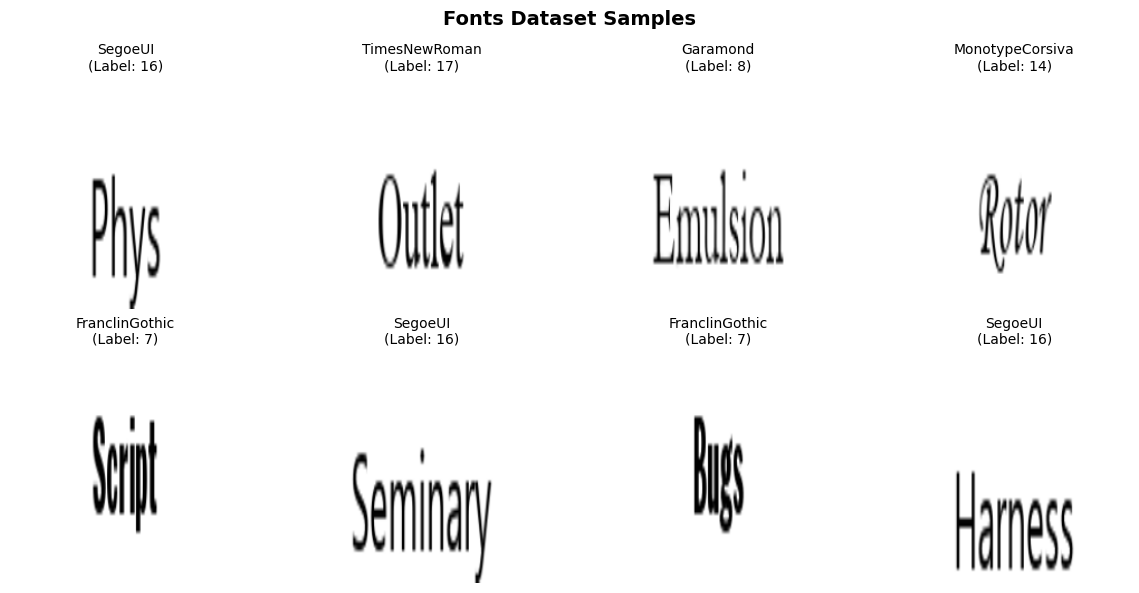


Sample details:
Image shape: torch.Size([3, 224, 224])
Label: 16
Class name: SegoeUI


In [26]:
visualize_samples(fonts_train_dataset, num_samples=8, title="Fonts Dataset Samples")

# Examine a single sample
sample_idx = 0
image, label = fonts_train_dataset[sample_idx]

print(f"\nSample details:")
print(f"Image shape: {image.shape}")
print(f"Label: {label}")
print(f"Class name: {list(fonts_train_dataset.class_map.keys())[list(fonts_train_dataset.class_map.values()).index(label)]}")

---

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import kagglehub
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Extra Practice Dataset: Bone Fracture Split Classification

![image.png](https://storage.googleapis.com/kaggle-datasets-images/5013401/8421103/1dc812e422a61e5d54d7f0760c0aeeb1/dataset-cover.png?t=2024-05-15-13-48-14)

##### This dataset contains **X-ray images** of various types of bone fractures, categorized into **12 classes**.




In [28]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shyamgupta196/bone-fracture-split-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'bone-fracture-split-classification' dataset.
Path to dataset files: /kaggle/input/bone-fracture-split-classification


##### Note: You can build a custom dataset class or use any torch built-in dataset classes (e.g. TensorDataset, ImageFolder,...)

In [29]:
class_to_idx = {
    "Avulsion fracture": 0,
    "Comminuted fracture": 1,
    "Compression-Crush fracture": 2,
    "Fracture Dislocation": 3,
    "Greenstick fracture": 4,
    "Hairline Fracture": 5,
    "Impacted fracture": 6,
    "Intra-articular fracture": 7,
    "Longitudinal fracture": 8,
    "Oblique fracture": 9,
    "Pathological fracture": 10,
    "Spiral Fracture": 11
}


In [30]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])


# Create dataset objects
train_dataset = ImageFolder(os.path.join(path,"train"), transform=transform)
valid_dataset = ImageFolder(os.path.join(path,"test"), transform=test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2)

# Check a batch of images
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}, Labels: {labels}")

Batch shape: torch.Size([32, 3, 224, 224]), Labels: tensor([ 9,  2,  7,  1,  2,  7, 10,  8,  1,  8,  7,  7,  0,  0,  1,  6,  5,  2,
         2, 11,  5,  6,  2,  8,  1, 10,  6,  0,  4,  6, 10,  8])


### Display some images from the dataset

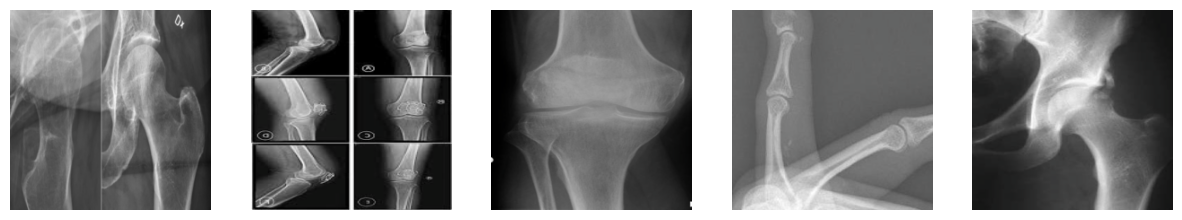

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Define mean & std for denormalization (EfficientNet Preprocessing)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Display 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

imgs_indices = [270,233,110,89,15]

for i in range(5):
    img, label = train_dataset[imgs_indices[i]]  # Load image & label

    # Convert tensor to numpy for visualization
    img_np = img.numpy().transpose(1, 2, 0)  # (C, H, W) → (H, W, C)

    # Denormalize the image
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)

    # Show image
    axes[i].imshow(img_np)
    axes[i].axis('off')

plt.show()

### Contributed by: Abdulellah Mojalled

![image.png](https://i.imgur.com/a3uAqnb.png)